In [9]:
import numpy as np
import scipy
import wfdb
from utils import awgn, calc_snr
from gmm_denoiser import GMMRecoverer
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
def make_phi(M, N):
    """
    generate random orthonormal measurement matrix for compressive sensing
    """
    phi = np.random.normal(0, 1, (M, N))
    phi = scipy.linalg.orth(phi.T).T
    return phi

In [11]:
rec104 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/104")
rec105 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/105")

In [12]:
train_signals = [rec104.p_signal[:10800, 0]]

In [13]:
test_signals = [
    rec105.p_signal[:512, 0],
    rec105.p_signal[512:1024, 0],
    rec105.p_signal[1024:1536, 0],
]

In [14]:
recoverer = GMMRecoverer(
    gmm_n_components=10, patch_size=30, train_signals=train_signals
)
recoverer.fit()

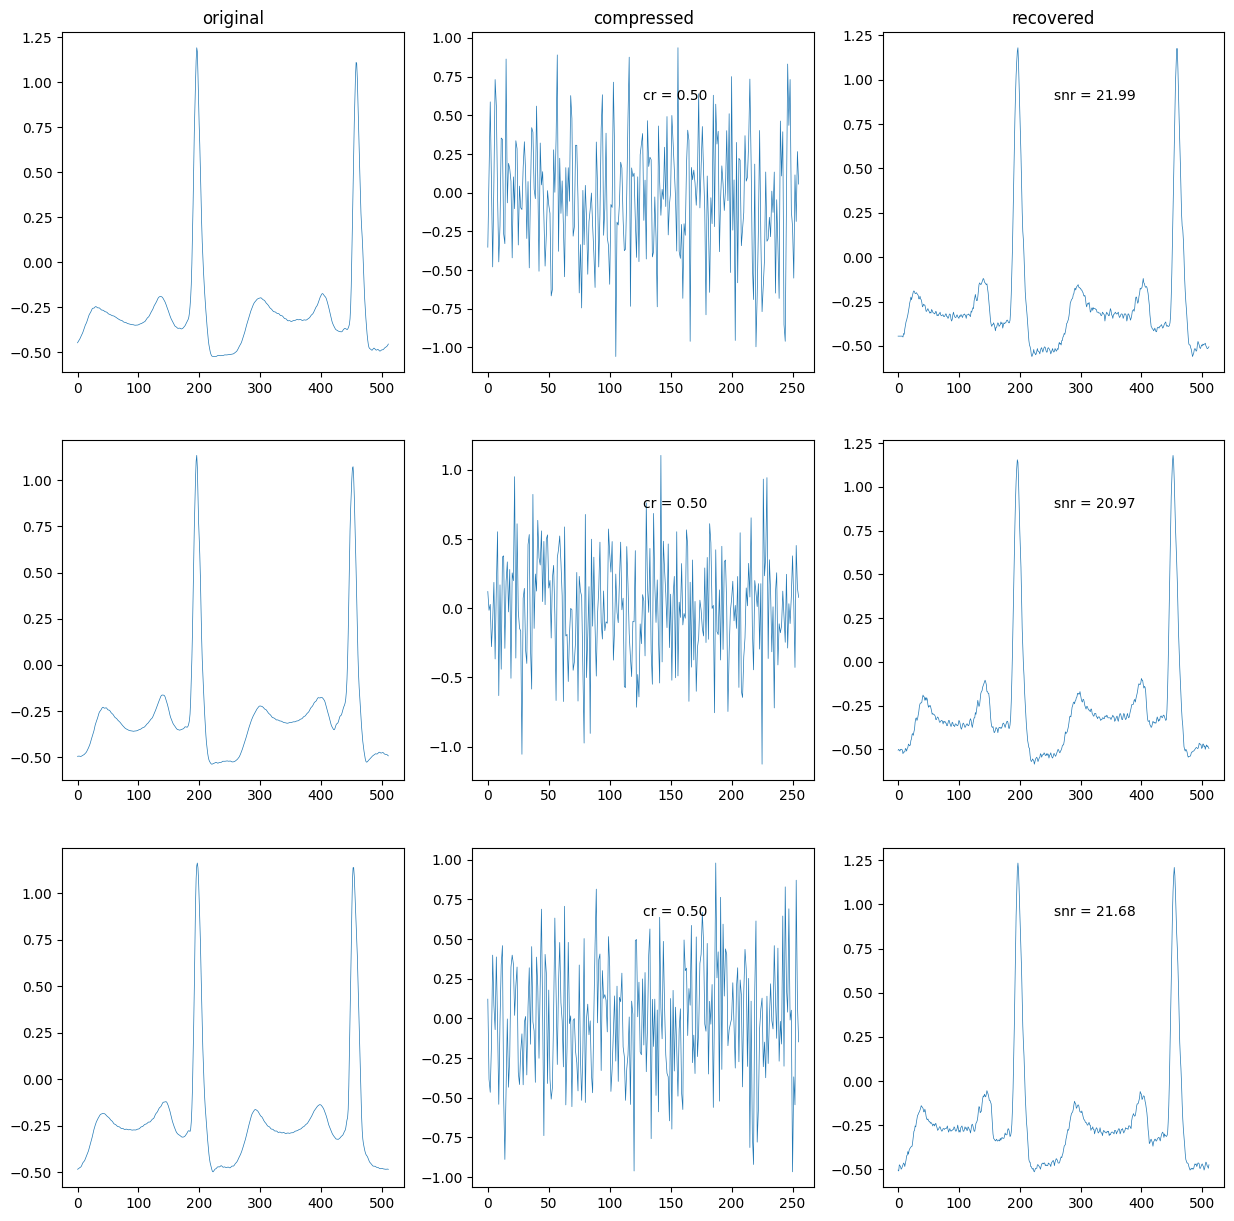

In [16]:
cr = 0.50
snr_db = 20
fig, axs = plt.subplots(len(test_signals), 3, figsize=(15, 15))
axs[0, 0].set_title("original")
axs[0, 1].set_title("compressed")
axs[0, 2].set_title("recovered")
for i, nf in enumerate(test_signals):
    N = len(nf)
    M = int((1 - cr) * N)
    PHI = make_phi(M, N)
    ns = awgn(PHI @ nf, snr_db=snr_db)
    nf_pred = recoverer.recover(
        ns, phi=PHI, snr_db_est=snr_db, lr=0.3, iters=150, switch_t=20
    )
    ax1, ax2, ax3 = axs[i]

    ax1.plot(nf_pred, linewidth=0.5)

    ax2.plot(ns, linewidth=0.5)
    ax2.text(0.5, 0.8, f"cr = {cr:.2f}", transform=ax2.transAxes)

    ax3.plot(nf, linewidth=0.5)
    ax3.text(0.5, 0.8, f"snr = {calc_snr(nf, nf_pred):.2f}", transform=ax3.transAxes)
fig.savefig(f"out/ecg_rec_out/cr{cr:.2f},snr{snr_db}db.png")